In [10]:
import os, s3fs, json
import xarray as xr
import dask.bag as db

from dask.distributed import Client
from datetime import datetime, timedelta
from kerchunk.hdf import SingleHdf5ToZarr

In [11]:
def generate_kerchunk(netcdf):
    with fs.open(netcdf, mode='rb', anon=True) as ncfile:
        json_url = f's3://azavea-noaa-hydro-data/{netcdf[:-3]}.json'
        with fs.open(json_url, mode='wb') as outfile:
            outfile.write(
                json.dumps(
                    SingleHdf5ToZarr(
                        ncfile, f's3://{netcdf}'
                    ).translate()
                ).encode()
            )
            return json_url

In [12]:
def read_kerchunk(netcdf):
    with fs.open(netcdf, mode='rb', anon=True) as ncfile:
        return SingleHdf5ToZarr(ncfile, f's3://{netcdf}').translate()

In [13]:
fs = s3fs.S3FileSystem()
yesterday = (datetime.now() - timedelta(days=1)).strftime('%Y%m%d')

netcdf_url = f's3://noaa-nwm-pds/nwm.{yesterday}/short_range/nwm.t*z.short_range.channel_rt.*.conus.nc'
netcdfs = fs.glob(netcdf_url)

In [14]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 30.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44785,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 30.90 GiB
Comm: tcp://127.0.0.1:41581,Total threads: 1
Dashboard: http://127.0.0.1:33701/status,Memory: 7.72 GiB
Nanny: tcp://127.0.0.1:38363,


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.268366 to fit


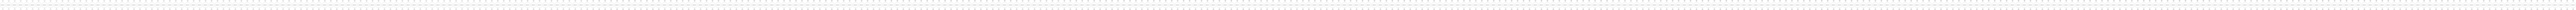

In [15]:
bag = db.from_sequence(netcdfs, npartitions=len(netcdfs)).map(generate_kerchunk)
bag.visualize()

In [16]:
%%time

bag.compute()

CPU times: user 3.38 s, sys: 371 ms, total: 3.75 s
Wall time: 28.2 s


['s3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/short_range/nwm.t00z.short_range.channel_rt.f001.conus.json',
 's3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/short_range/nwm.t00z.short_range.channel_rt.f002.conus.json',
 's3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/short_range/nwm.t00z.short_range.channel_rt.f003.conus.json',
 's3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/short_range/nwm.t00z.short_range.channel_rt.f004.conus.json',
 's3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/short_range/nwm.t00z.short_range.channel_rt.f005.conus.json',
 's3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/short_range/nwm.t00z.short_range.channel_rt.f006.conus.json',
 's3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/short_range/nwm.t00z.short_range.channel_rt.f007.conus.json',
 's3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/short_range/nwm.t00z.short_range.channel_rt.f008.conus.json',
 's3://azavea-noaa-hydro-data/noaa-nwm-pds/nwm.20230312/

In [20]:
# Run the following one by one after the computation above is completed. If run too quickly it shutsdown the client before the work is done.

# client.shutdown()
# client.close()